# Описание проекта

# Прогнозирование оттока клиентов оператора связи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Цель работы

Наша цель - разработать модель с заданными характеристиками в поставленные сроки. Моделью будет пользоваться заказчик, у него цель - выявлять клиентов которые планируют уйти.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

contract.csv — информация о договоре;

personal.csv — персональные данные клиента;

internet.csv — информация об интернет-услугах;

phone.csv — информация об услугах телефонии.

In [546]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.dummy import DummyClassifier
import itertools   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install -q --no-deps skimpy 

from skimpy import clean_columns
import seaborn as sns   

!pip install -q phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier


RANDOM_STATE = 130223

pd.set_option('display.max_columns', None)
numeric_columns = ['monthly_charges', 'total_charges', 'total_days']
categorial_columns = [
    'type',
    'paperless_billing',
    'payment_method',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'internet_service', 
    'online_security', 
    'online_backup', 
    'device_protection', 
    'tech_support', 
    'streaming_tv', 
    'streaming_movies', 
    'multiple_lines',
]




In [547]:
contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

In [548]:
# вывод полезных функций

def analyze_df(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(5))
    display(df.describe())
    df.info()
    
def isna_df(df):
    print('Количество пропусков в каждом столбце')    
    print(df.isna().mean())

In [549]:
analyze_df(contract_df)

Количество стобцов: 8

Количество строк: 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 7043 entries, 0 to 7042

Data columns (total 8 columns):

 #   Column            Non-Null Count  Dtype  

---  ------            --------------  -----  

 0   customerID        7043 non-null   object 

 1   BeginDate         7043 non-null   object 

 2   EndDate           7043 non-null   object 

 3   Type              7043 non-null   object 

 4   PaperlessBilling  7043 non-null   object 

 5   PaymentMethod     7043 non-null   object 

 6   MonthlyCharges    7043 non-null   float64

 7   TotalCharges      7043 non-null   object 

dtypes: float64(1), object(7)

memory usage: 440.3+ KB


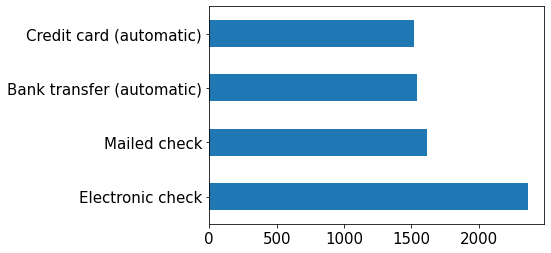

In [550]:
contract_df['PaymentMethod'].value_counts().plot.barh();


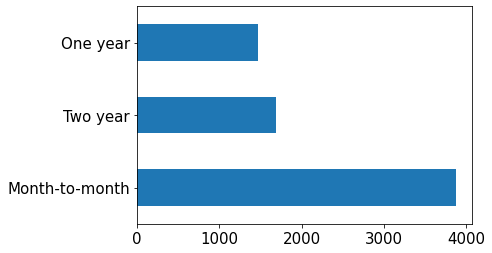

In [551]:
contract_df['Type'].value_counts().plot.barh();


In [552]:
analyze_df(personal_df)

Количество стобцов: 5

Количество строк: 7043


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 7043 entries, 0 to 7042

Data columns (total 5 columns):

 #   Column         Non-Null Count  Dtype 

---  ------         --------------  ----- 

 0   customerID     7043 non-null   object

 1   gender         7043 non-null   object

 2   SeniorCitizen  7043 non-null   int64 

 3   Partner        7043 non-null   object

 4   Dependents     7043 non-null   object

dtypes: int64(1), object(4)

memory usage: 275.2+ KB


In [553]:
analyze_df(internet_df)

Количество стобцов: 8

Количество строк: 5517


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 5517 entries, 0 to 5516

Data columns (total 8 columns):

 #   Column            Non-Null Count  Dtype 

---  ------            --------------  ----- 

 0   customerID        5517 non-null   object

 1   InternetService   5517 non-null   object

 2   OnlineSecurity    5517 non-null   object

 3   OnlineBackup      5517 non-null   object

 4   DeviceProtection  5517 non-null   object

 5   TechSupport       5517 non-null   object

 6   StreamingTV       5517 non-null   object

 7   StreamingMovies   5517 non-null   object

dtypes: object(8)

memory usage: 344.9+ KB


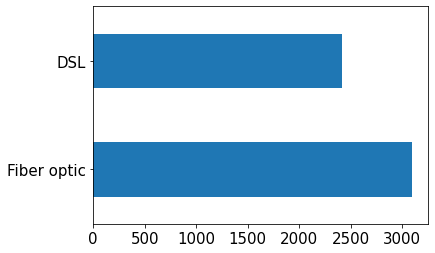

In [554]:
internet_df['InternetService'].value_counts().plot.barh();


In [555]:
analyze_df(phone_df)

Количество стобцов: 2

Количество строк: 6361


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 6361 entries, 0 to 6360

Data columns (total 2 columns):

 #   Column         Non-Null Count  Dtype 

---  ------         --------------  ----- 

 0   customerID     6361 non-null   object

 1   MultipleLines  6361 non-null   object

dtypes: object(2)

memory usage: 99.5+ KB


In [556]:
isna_df(contract_df)

Количество пропусков в каждом столбце

customerID          0.0

BeginDate           0.0

EndDate             0.0

Type                0.0

PaperlessBilling    0.0

PaymentMethod       0.0

MonthlyCharges      0.0

TotalCharges        0.0

dtype: float64


In [557]:
isna_df(personal_df)

Количество пропусков в каждом столбце

customerID       0.0

gender           0.0

SeniorCitizen    0.0

Partner          0.0

Dependents       0.0

dtype: float64


In [558]:
isna_df(internet_df)

Количество пропусков в каждом столбце

customerID          0.0

InternetService     0.0

OnlineSecurity      0.0

OnlineBackup        0.0

DeviceProtection    0.0

TechSupport         0.0

StreamingTV         0.0

StreamingMovies     0.0

dtype: float64


In [559]:
isna_df(phone_df)

Количество пропусков в каждом столбце

customerID       0.0

MultipleLines    0.0

dtype: float64


# Вывод

После первичного знакомства с данными выявили следующее:

1) Пропусков в данных нет

2) В датафрейме contract_df - столбцы 'BeginDate' и 'EndDate' требуется перевести в формат даты

3) В каждом датафрейме требуется перевести названия колонок к единому регистру

# 1. Первичная подготовка данных

In [560]:
contract_df = clean_columns(contract_df)

contract_df

8 column names have been cleaned

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [561]:
personal_df = clean_columns(personal_df)

personal_df

4 column names have been cleaned

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [562]:
internet_df = clean_columns(internet_df)

internet_df

8 column names have been cleaned

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [563]:
phone_df = clean_columns(phone_df)

phone_df

2 column names have been cleaned

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


Создадим новый столбец Churn (от англ. отток), который будет означать отказался клиент от услуг или нет.
Если значение в столбце EndDate равно "No" - клиент не ушел и целевой признак равен 0.
Если дата ухода есть, то целевой признак равен 1.

In [564]:
contract_df['churn'] = (contract_df['end_date'] != 'No').astype(int)
contract_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [565]:
# заменим все значения "No" на дату выгрузки датасета
contract_df['end_date'] = contract_df['end_date'].replace(['No'], ['2020-02-01'])
print(contract_df[contract_df['end_date'] == 'No'].shape[0])

0


In [566]:
# переведем столбцы в формат даты
    
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'], format='%Y-%m-%d')
contract_df['end_date'] = pd.to_datetime(contract_df['end_date'], format='%Y-%m-%d')
contract_df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 7043 entries, 0 to 7042

Data columns (total 9 columns):

 #   Column             Non-Null Count  Dtype         

---  ------             --------------  -----         

 0   customer_id        7043 non-null   object        

 1   begin_date         7043 non-null   datetime64[ns]

 2   end_date           7043 non-null   datetime64[ns]

 3   type               7043 non-null   object        

 4   paperless_billing  7043 non-null   object        

 5   payment_method     7043 non-null   object        

 6   monthly_charges    7043 non-null   float64       

 7   total_charges      7043 non-null   object        

 8   churn              7043 non-null   int64         

dtypes: datetime64[ns](2), float64(1), int64(1), object(5)

memory usage: 495.3+ KB


Создадим новый столбец total_days, который будет означать, сколько пользователь пользовался услугами

In [567]:
contract_df['total_days'] = (contract_df['end_date'] - contract_df['begin_date']).dt.days

In [568]:
# переведем столбец total_charges в численный тип
contract_df['total_charges'] = pd.to_numeric(contract_df['total_charges'], errors ='coerce')

In [569]:
# взглянем на пропуски в данных
contract_df[contract_df['total_charges'].isnull()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,total_days
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Судя по столбцу total_days, все пользователи с пропусками в столбце total_charges - новички и начали пользоваться услугами оператора недавно. Можно смело заполнить столбец нулями.

In [570]:
contract_df['total_charges'] = contract_df['total_charges'].fillna(0)
contract_df[contract_df['total_charges'].isnull()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,total_days


В таблицы internet_df и phone_df добавим по признаку, чтобы при объединении в единый датасет, у нас были пометки у пользователей кто какими услугами пользуется.

In [571]:
internet_df['internet'] = 1
phone_df['phone'] = 1

Все значительные исправления и корректировки в датафреймах сделаны - можно приступить к объединению всех данных воедино.

In [572]:
churn_df = contract_df \
    .merge(personal_df, how='left', on='customer_id') \
    .merge(internet_df, how='left', on='customer_id') \
    .merge(phone_df, how='left', on='customer_id') 

In [573]:
# проверим уникальность id в получившейся таблице
churn_df['customer_id'].is_unique 

True

In [574]:
# выставим столбец customer_id - как единый индекс
churn_df = churn_df.set_index('customer_id')

In [575]:
analyze_df(churn_df)

Количество стобцов: 23

Количество строк: 7043


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet,multiple_lines,phone
customer_id,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,1.0,NaN,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,1.0,No,1.0
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,1.0,No,1.0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,1.0,NaN,NaN
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,1.0,No,1.0


,monthly_charges,total_charges,churn,total_days,senior_citizen,internet,phone
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,5517.0,6361.0
mean,64.761692,2279.734304,0.265370,985.996166,0.162147,1.0,1.0
std,30.090047,2266.794470,0.441561,747.587844,0.368612,0.0,0.0
min,18.250000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,35.500000,398.550000,0.000000,273.000000,0.000000,1.0,1.0
50%,70.350000,1394.550000,0.000000,883.000000,0.000000,1.0,1.0
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000,1.0,1.0
max,118.750000,8684.800000,1.000000,2191.000000,1.000000,1.0,1.0


<class 'pandas.core.frame.DataFrame'>

Index: 7043 entries, 7590-VHVEG to 3186-AJIEK

Data columns (total 23 columns):

 #   Column             Non-Null Count  Dtype         

---  ------             --------------  -----         

 0   begin_date         7043 non-null   datetime64[ns]

 1   end_date           7043 non-null   datetime64[ns]

 2   type               7043 non-null   object        

 3   paperless_billing  7043 non-null   object        

 4   payment_method     7043 non-null   object        

 5   monthly_charges    7043 non-null   float64       

 6   total_charges      7043 non-null   float64       

 7   churn              7043 non-null   int64         

 8   total_days         7043 non-null   int64         

 9   gender             7043 non-null   object        

 10  senior_citizen     7043 non-null   int64         

 11  partner            7043 non-null   object        

 12  dependents         7043 non-null   object        

 13  internet_service   5517 non-null   

Пропуски в столбцах internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines - по всей видимости, означают, что услуги не были подключены, поэтому можем заменить пропуски на значение 0. 

In [576]:
for column in ('internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 
               'streaming_movies', 'multiple_lines'):
    churn_df[column] = churn_df[column].fillna('No')

In [577]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>

Index: 7043 entries, 7590-VHVEG to 3186-AJIEK

Data columns (total 23 columns):

 #   Column             Non-Null Count  Dtype         

---  ------             --------------  -----         

 0   begin_date         7043 non-null   datetime64[ns]

 1   end_date           7043 non-null   datetime64[ns]

 2   type               7043 non-null   object        

 3   paperless_billing  7043 non-null   object        

 4   payment_method     7043 non-null   object        

 5   monthly_charges    7043 non-null   float64       

 6   total_charges      7043 non-null   float64       

 7   churn              7043 non-null   int64         

 8   total_days         7043 non-null   int64         

 9   gender             7043 non-null   object        

 10  senior_citizen     7043 non-null   int64         

 11  partner            7043 non-null   object        

 12  dependents         7043 non-null   object        

 13  internet_service   7043 non-null   

# Итог первого этапа



На первом этапе проекта сделали следующее: названия столбцов были приведены к единому регистру, столбцы даты начала и окончания пользования договором приведены к нужному формату даты, был добавлен новый столбец Churn (от англ. отток), который будет означать отказался клиент от услуг или нет, также добавили столбец, показывающий, сколько суммарно дней человек являлся клиентом оператора связи. Были объединены все данные в один файл и настроено индексирование. 

# 2. Исследовательский анализ данных

Взглянем на распределение значений для категориальных данных

# Распределение классов целевого признака

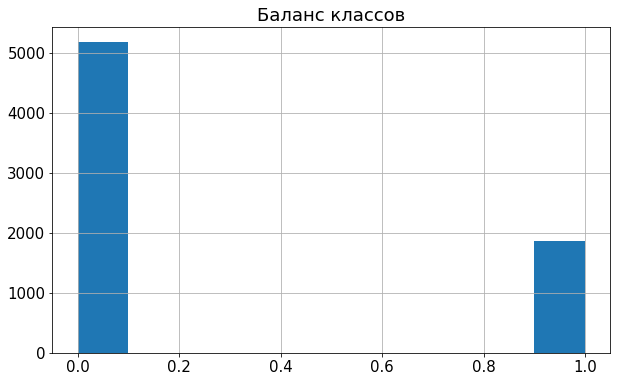

In [578]:
churn_df['churn'].hist(figsize=(10,6))
plt.title('Баланс классов');

Явно заметно большинство среди клиентов, которые на момент выгрузки данных пользовались сервисом

#  Ежемесячные платежи

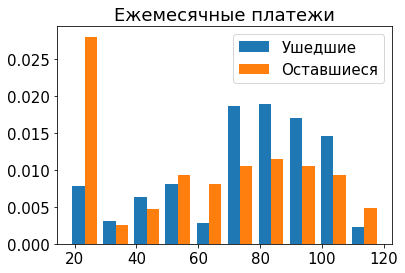

In [579]:
plt.hist([churn_df[churn_df.churn == 1].monthly_charges, churn_df[churn_df.churn == 0].monthly_charges], label=['Ушедшие', 'Оставшиеся'], density=True);
plt.legend();
plt.title('Ежемесячные платежи');
plt.show();

Заметнее всего потери среди клиентов с ежемесячными платежами от 70 до 100

# Распределение услуг

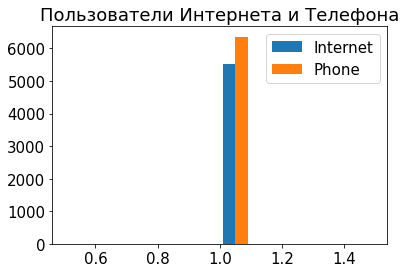

In [580]:
plt.hist([churn_df[churn_df.internet == 1].internet, churn_df[churn_df.phone == 1].phone], label=['Internet', 'Phone']);
plt.legend();
plt.title('Пользователи Интернета и Телефона');
plt.show();

Перевес распределения услуг на стороне телефонии, услугами заказчика как интернет-провайдера клиенты пользуются реже

# Распределение платежей

No handles with labels found to put in legend.


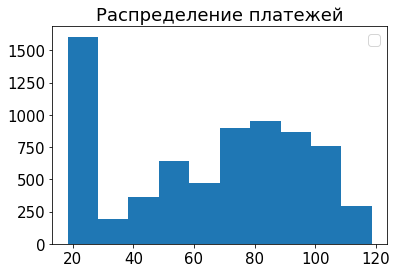

In [581]:
#churn_df['monthly_charges'].hist(label=['Internet', 'Phone']))


plt.hist(churn_df['monthly_charges']);
plt.legend();
plt.title('Распределение платежей');
plt.show();

Видно, что большая часть пользователей платит менее 30 в месяц. Рассмотрим их отдельно.

In [582]:
low_cost = churn_df.query('monthly_charges < 30')

low_cost.head(5)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet,multiple_lines,phone
customer_id,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,1.0,No,NaN
6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.90,0,306,Female,0,No,No,DSL,Yes,No,No,No,No,No,1.0,No,NaN
7469-LKBCI,2018-10-01,2020-02-01,Two year,No,Credit card (automatic),18.95,326.80,0,488,Male,0,No,No,No,No,No,No,No,No,No,NaN,No,1.0
8191-XWSZG,2015-10-01,2020-02-01,One year,No,Mailed check,20.65,1022.95,0,1584,Female,0,No,No,No,No,No,No,No,No,No,NaN,No,1.0
1680-VDCWW,2019-02-01,2020-02-01,One year,No,Bank transfer (automatic),19.80,202.25,0,365,Male,0,Yes,No,No,No,No,No,No,No,No,NaN,No,1.0


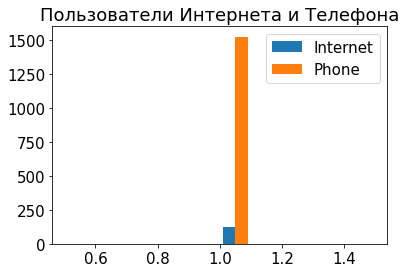

In [583]:
plt.hist([low_cost[low_cost.internet == 1].internet, low_cost[low_cost.phone == 1].phone], label=['Internet', 'Phone']);
plt.legend();
plt.title('Пользователи Интернета и Телефона');
plt.show();

Объяснение такого количества пользователей, платящих менее 30 в месяц крылось в том, что эти клиенты пользовались услугами сотовой связи, которая стоит помесячно дешевле. 

# Тип подключения

Text(0.5, 1.0, 'Способы оплаты')

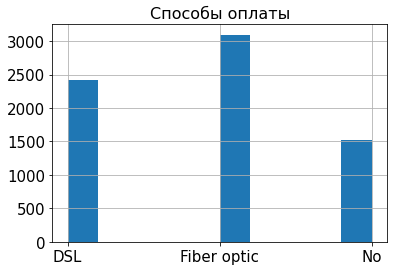

In [584]:
churn_df['internet_service'].hist()

plt.title('Способы оплаты', fontsize = 16)

Самый частый способ подключения - оптоволокно

# Cпособы оплаты

Text(0.5, 1.0, 'Способы оплаты')

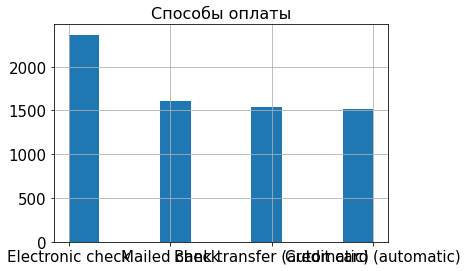

In [585]:
churn_df['payment_method'].hist()

plt.title('Способы оплаты', fontsize = 16)

Преобладающий способ оплаты - электронный чек

# Рассмотрим матрицу корреляции в графическом и текстовом видах

In [588]:
phik_overview = churn_df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'churn', 'total_days', 'senior_citizen', 'internet', 'phone']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable internet for analysis 1. Dropping this column

  warnings.warn(

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable phone for analysis 1. Dropping this column

  warnings.warn(


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
begin_date,1.00,0.58,0.77,0.08,0.46,0.42,0.82,0.50,1.00,0.01,0.05,0.47,0.21,0.19,0.40,0.45,0.46,0.40,0.36,0.37,0.43
end_date,0.58,1.00,0.36,0.16,0.21,0.32,0.25,1.00,0.41,0.00,0.12,0.12,0.13,0.29,0.14,0.07,0.05,0.13,0.05,0.05,0.03
type,0.77,0.36,1.00,0.11,0.28,0.39,0.51,0.25,0.66,0.00,0.09,0.18,0.15,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.07
paperless_billing,0.08,0.16,0.11,1.00,0.37,0.47,0.21,0.30,0.00,0.00,0.24,0.01,0.17,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.25
payment_method,0.46,0.21,0.28,0.37,1.00,0.40,0.35,0.45,0.38,0.00,0.29,0.24,0.22,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.34
monthly_charges,0.42,0.32,0.39,0.47,0.40,1.00,0.76,0.36,0.41,0.01,0.30,0.20,0.18,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.68
total_charges,0.82,0.25,0.51,0.21,0.35,0.76,1.00,0.28,0.84,0.00,0.15,0.42,0.12,0.51,0.55,0.65,0.67,0.57,0.66,0.67,0.61
churn,0.50,1.00,0.25,0.30,0.45,0.36,0.28,1.00,0.47,0.00,0.23,0.23,0.25,0.20,0.26,0.13,0.10,0.25,0.10,0.09,0.06
total_days,1.00,0.41,0.66,0.00,0.38,0.41,0.84,0.47,1.00,0.00,0.03,0.49,0.21,0.02,0.42,0.47,0.47,0.42,0.36,0.37,0.43
gender,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00


interval columns not set, guessing: ['monthly_charges', 'total_charges', 'churn', 'total_days', 'senior_citizen', 'internet', 'phone']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable internet for analysis 1. Dropping this column

  warnings.warn(

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable phone for analysis 1. Dropping this column

  warnings.warn(


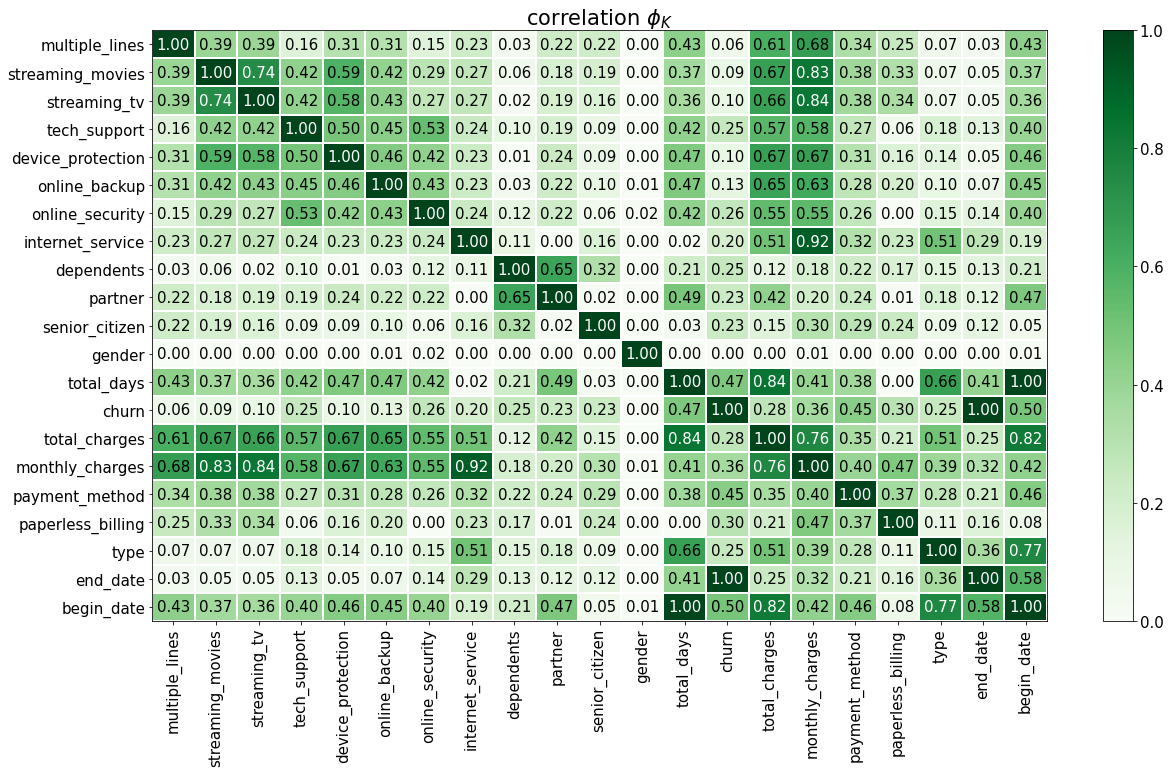

In [589]:
phik_overview = churn_df.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(18, 11))
plt.tight_layout()

Можно сделать вывод, что чем дольше клиент пользовался услугами, тем меньше вероятность, что он уйдет, а также, что чем выше цена за услуги в месяц, тем больше вероятность, что клиент уйдет

In [590]:
churn_df[numeric_columns].corr()

,monthly_charges,total_charges,total_days
monthly_charges,1.000000,0.651174,0.247754
total_charges,0.651174,1.000000,0.826109
total_days,0.247754,0.826109,1.000000


Явно заметна тесная связь между total_days и total_charges - чем дольше клиент оставался абонентом, тем больше суммарно платежей он оставил компании. От мультиколлинеарности нужно избавляться - удалим поле total_charges. 

In [591]:
churn_df = churn_df.drop(['total_charges'], axis = 1)
numeric_columns = ['monthly_charges', 'total_days']

In [592]:
churn_df.columns

Index(['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'churn', 'total_days', 'gender', 'senior_citizen',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'internet', 'multiple_lines', 'phone'],
      dtype='object')

Удалим также ненужные поля 

In [593]:
churn_df = churn_df.drop(['begin_date','end_date','internet','phone'], axis= 1)

# Подготовка данных для моделей

Применим технику кодирования данных One Hot Encoding

In [594]:
churn_df.head(5)

,type,paperless_billing,payment_method,monthly_charges,churn,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.95,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [595]:
# разделим выборки на обучающую и тестовую

target = churn_df['churn']
features = churn_df.drop('churn', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, stratify = target, random_state= RANDOM_STATE) 


print(features_train.shape)
print(features_test.shape)

(5282, 17)

(1761, 17)


In [ ]:
# проведем масштабирование количественных признаков

scaler = StandardScaler()

features_train_scaled = pd.DataFrame(scaler.fit_transform(features_train[numeric_columns]), columns=[numeric_columns], index=features_train.index)


features_test_scaled = pd.DataFrame(scaler.transform(features_test[numeric_columns]), columns=[numeric_columns], index=features_test.index)



In [597]:
enc = OneHotEncoder(drop='first', handle_unknown='error')

features_train_ohe = enc.fit_transform(features_train[categorial_columns])

features_test_ohe = enc.transform(features_test[categorial_columns])

features_train_lr = pd.concat([features_train_scaled, pd.DataFrame(features_train_ohe.toarray(), index= features_train.index)], axis=1)
features_test_lr = pd.concat([features_test_scaled, pd.DataFrame(features_test_ohe.toarray(), index= features_test.index)], axis=1)



Проверим распределение классов на графике

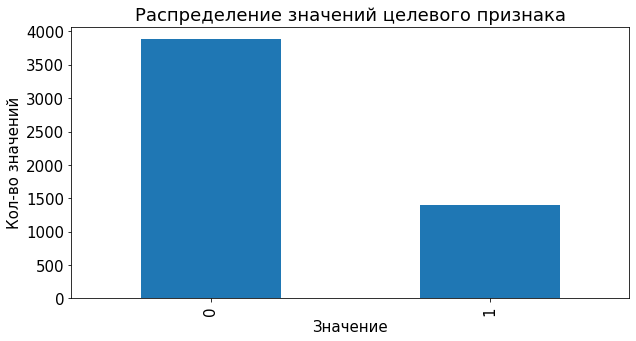

0    3880
1    1402
Name: churn, dtype: int64

In [598]:
target_train.value_counts().plot(
    kind='bar', 
    figsize=(10, 5), 
    legend=False, 
    title='Распределение значений целевого признака', 
).set(xlabel='Значение', ylabel='Кол-во значений')
plt.show()


target_train.value_counts()

В виду того, что метрика ROC_AUC не чувствительна к дисбалансу - оставим соотношение классов в текущей ситуации и перейдем к обучению моделей.

# Обучение моделей

# LogisticRegression

In [602]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

model = LogisticRegression(solver='lbfgs', n_jobs=-1, class_weight='balanced')

search = GridSearchCV(model, params, cv=5, scoring='roc_auc', error_score="raise")
search.fit(features_train_lr, target_train)

best_auc_lr = round(search.best_score_, 2)        # вынесем в переменную метрику для добавления в финальную таблицу

print('Лучшие параметры:', search.best_params_)
print('Лучший показатель метрики AUC-ROC:', best_auc_lr)


Лучшие параметры: {'C': 100}

Лучший показатель метрики AUC-ROC: 0.84


# RandomForestClassifier

In [603]:
model =  RandomForestClassifier(random_state = RANDOM_STATE, class_weight='balanced')
params = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100], 
}
search =GridSearchCV(estimator=model,
                          param_grid = params,
                          scoring='roc_auc',
                          cv=5,
                         )

search.fit(features_train_lr, target_train)
best_auc_rf = round(search.best_score_, 2)
print('Лучшие параметры:', search.best_params_)
print('Лучший показатель метрики:', best_auc_rf)


Лучшие параметры: {'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}

Лучший показатель метрики: 0.86


# CatBoostClassifier

In [610]:
params = {
    'learning_rate': [0.1, 0.3],
    'iterations': [50, 100],
    'l2_leaf_reg': [3, 9]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

search = GridSearchCV(model, params, cv=5, scoring='roc_auc')
search.fit(features_train_lr, target_train)
best_auc_cb = round(search.best_score_, 3)


print('Лучшие параметры:', search.best_params_)
print('Лучший показатель метрики:', best_auc_cb)

Лучшие параметры: {'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.3}

Лучший показатель метрики: 0.903


# Дамми модель для сравнения

In [605]:
model_const = DummyClassifier(strategy="most_frequent") 
model_const.fit(features_train, target_train)

probs_const = model_const.predict_proba(features_test)[:, 1]

best_auc_const = round(roc_auc_score(target_test, probs_const), 2)

print('Показание метрики AUC-ROC контантной модели', best_auc_const )


Показание метрики AUC-ROC контантной модели 0.5


# Сравнение рассматриваемых моделей

Проведем сравнение метрик полученных моделями

In [606]:
models = ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier', 'DummyClassifier']
best_auc = [best_auc_lr, best_auc_rf, best_auc_cb, best_auc_const]

model_comp = pd.DataFrame({'model': models,'best_auc': best_auc})

display(model_comp)

,model,best_auc
0,LogisticRegression,0.84
1,RandomForestClassifier,0.86
2,CatBoostClassifier,0.90
3,DummyClassifier,0.50


Модель CatBoostClassifier показала наиболее качественные результаты. Проверим ее работоспособность на тестовой выборке.

In [611]:
params = {
    'learning_rate': [0.3],
    'iterations': [100],
    'l2_leaf_reg': [3]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)


model.fit(features_test_lr, target_test)

probs = search.predict_proba(features_test_lr)[:, 1]

best_auc_cb_test = round(roc_auc_score(target_test, probs), 2)

predictions = model.predict(features_test_lr)
print('Лучшие параметры:', search.best_params_)
print('Показание метрики AUC-ROC для тестовой выборки модели CatBoosstlassifier: ', best_auc_cb_test)
print('Показание метрики Accuracy для тестовой выборки модели CatBoosstlassifier: ', round(model.score(features_test_lr, target_test), 2))

Лучшие параметры: {'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.3}

Показание метрики AUC-ROC для тестовой выборки модели CatBoosstlassifier:  0.93

Показание метрики Accuracy для тестовой выборки модели CatBoosstlassifier:  0.93


ROC-AUC score 0.980129009197449


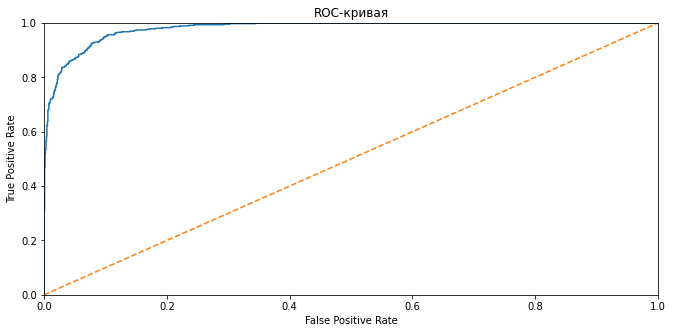

In [377]:
print('ROC-AUC score', roc_auc_score(target_test, probs))
    
fpr, tpr, thresholds = roc_curve(target_test, probs)

plt.figure(figsize=(11, 5))
    
plt.plot(fpr, tpr)
    
plt.plot([0, 1], [0, 1], linestyle='--')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
plt.title('ROC-кривая')
    
plt.show()

In [499]:
# совместим категориальные и количественные признаки 


cols = enc.get_feature_names_out()

numeric_cols =  np.array(['monthly_charges', 'total_days'])

otvet = np.concatenate((numeric_cols, cols), axis= 0 )

otvet

array(['monthly_charges', 'total_days', 'type_One year', 'type_Two year',
       'paperless_billing_Yes', 'payment_method_Credit card (automatic)',
       'payment_method_Electronic check', 'payment_method_Mailed check',
       'gender_Male', 'senior_citizen_1', 'partner_Yes', 'dependents_Yes',
       'internet_service_Fiber optic', 'internet_service_No',
       'online_security_Yes', 'online_backup_Yes',
       'device_protection_Yes', 'tech_support_Yes', 'streaming_tv_Yes',
       'streaming_movies_Yes', 'multiple_lines_Yes'], dtype=object)

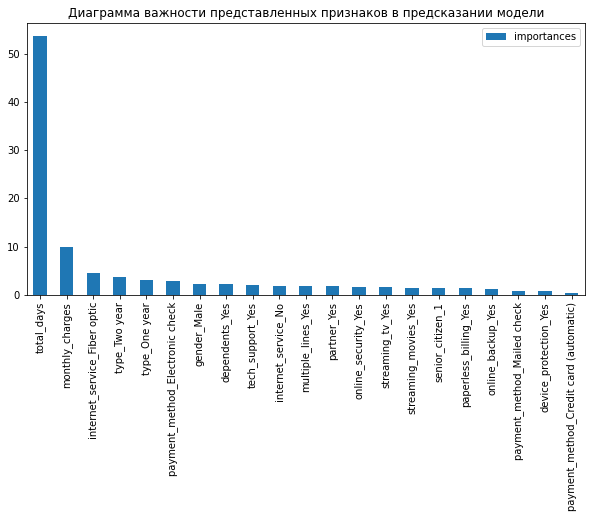

,importances
total_days,53.647178
monthly_charges,9.921851
internet_service_Fiber optic,4.473839
type_Two year,3.689110
type_One year,3.061505
payment_method_Electronic check,2.788723
gender_Male,2.184340
dependents_Yes,2.137513
tech_support_Yes,2.083724
internet_service_No,1.894006


In [498]:
importances_df = pd.DataFrame(search.best_estimator_.feature_importances_, index = otvet, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df.plot(kind='bar', figsize=(10, 5), title="Диаграмма важности представленных признаков в предсказании модели")
plt.show()

importances_df

Построим матрицу ошибок

In [503]:
print(confusion_matrix(target_test, predictions)) 


[[1264   30]

 [  89  378]]


Confusion matrix, without normalization

[[1264   30]

 [  89  378]]


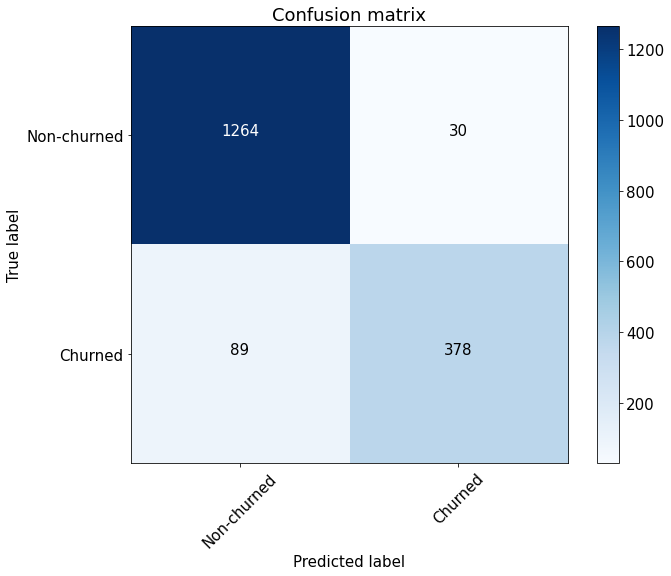

In [507]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(target_test, predictions)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Судя по матрице ошибок, итоговые результаты выбранной модели достаточно неплохие - 1264 истинно положительных предсказанных значений и 378 истинно отрицательных значений. 

# Итоговый вывод

1) В первую очередь мы ознакомились с данными, обработали пропуски, удалили неинформативные столбцы и избавились от дубликатов и аномалий. Добавили два новых столбца - целевой признак Churn, который означает отказался ли клиент от услуг и Total Days, который обозначает сколько по времени пользователь пользовался услугами.


2) Далее был проведен исследовательский анализ данных - проанализированы количественные и категоральные признаки, проведена попытка найти связь между ними и целевым признаком. Сформулированы следующие выводы: вероятность отказа от услуг со временем снижается и обычно отказывались от услуг те клиенты, чья ежемесячная плата была выше.

3) После этого была проведена подготовка данных к обучению моделей: применена техника OHE, датафрейм был разделен на обучающую и тестовую выборки, проведено масштабирование количественных признаков. 

4) Для обучения были выбраны три модели: LogisticRegression, RandomForestClassifier и CatBoostClassifier. Лучший результат показала модель CatBoostClassifier со значением метрики ROC-AUC равной 0.9. 

5) Модель CatBoostClassifier была проверена на тестовой выборке и показала наивысшую метрику.

6) По графику важности факторов можно сделать вывод, что наибольшей важностью обладает фактор того, сколько клиент пользуется услугами оператора, а также сколько он платит в месяц. 

# Отчет по решению

В ходе выполнения проекта сделал следующее: загрузил и ознакомился с данными, привел названия столбцов к единому регистру, столбцы даты начала и окончания пользования договором привел к нужному формату даты, добавил новый столбец Churn (от англ. отток), который будет означать отказался клиент от услуг или нет, также добавил столбец, показывающий, сколько суммарно дней человек являлся клиентом оператора связи. Были объединены все данные в один файл и настроено индексирование. Перед обучением были удалены признаки BeginDate, EndDate.

Следующим шагом был проведен исследовательский анализ данных, первым делом был выявлен дизбаланс классов.

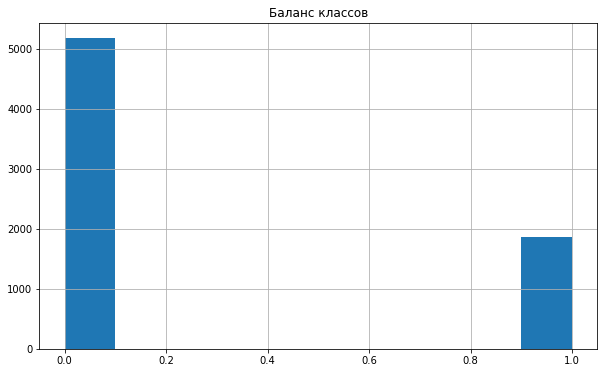

Из графика видно, что перевес на стороне оставшихся клиентов.

 

Далее, для построения представления о портрете ушедшего клиента вывел график ежемесячных платежей среди оставшихся и ушедших клиентов.

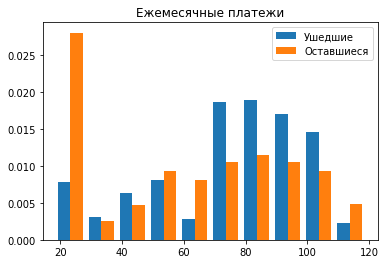

По нему стало ясно, что заметнее всего потери среди клиентов с ежемесячными платежами от 70 до 100.

 

Затем, был построен график распределения услуг заказчика, чтобы понять, чем чаще пользуются клиенты.

Перевес распределения услуг на стороне телефонии, услугами заказчика как интернет-провайдера клиенты пользуются реже

В связи с этим вывел график распределения платежей среди клиентов.

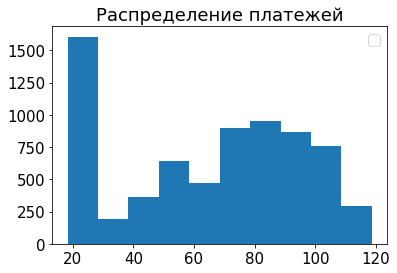

Видно, что большая часть пользователей платит менее 30 в месяц, что и подтверждает предположение о том, что чаще всего клиенты пользуются услугами телефонии.

Далее, рассмотрел матрицу корреляции признаков датасета.

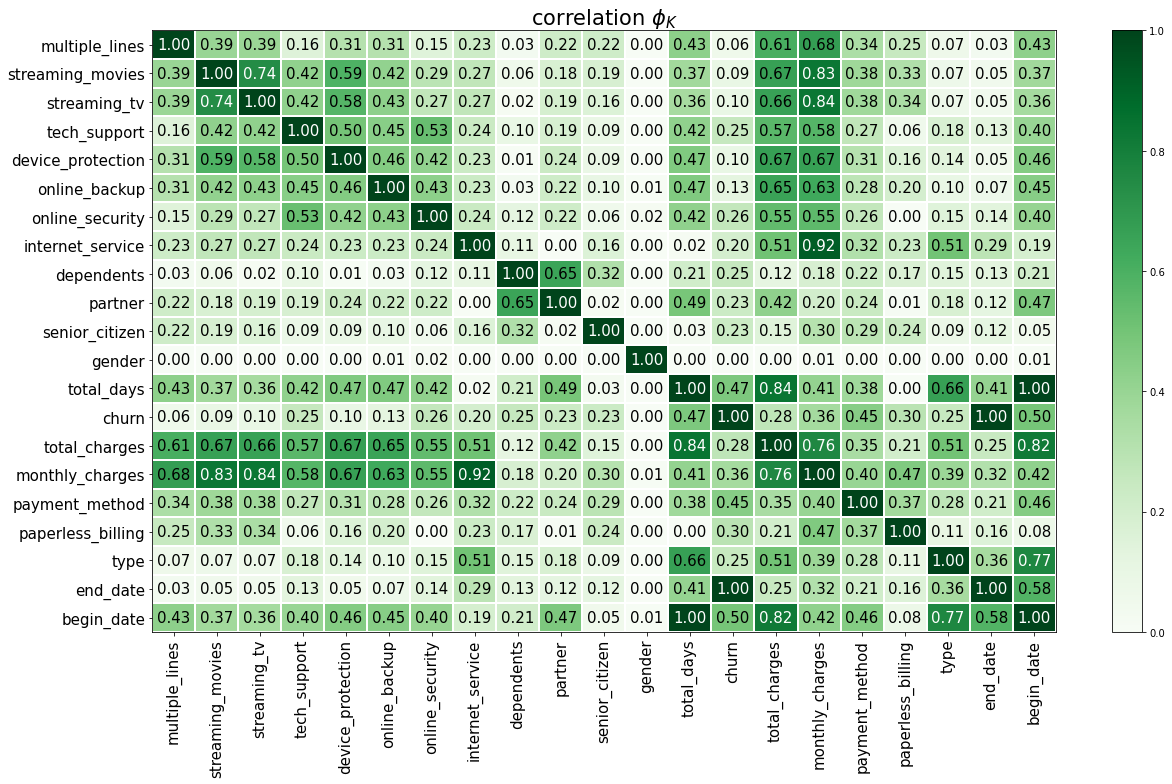

Сделал вывод, что чем дольше клиент пользовался услугами, тем меньше вероятность, что он уйдет, а также, что чем выше цена за услуги в месяц, тем больше вероятность, что клиент уйдет

Следующим шагом была подготовка к обучению модели, масштабировал количественные признаки методом стандартизации при помощи StandardScaler для того что бы числовые признаки привести к одной мерности, а категориальные признаки закодировал техникой OneHotEncoding.

Далее были обучены 3 модели для выявления лучшей для дальнейшей работы с ней, модели были выбраны RandomForestClassifier, LogisticRegression, CatBoostClassifier.

Для сравнения и выбора лучшей модели вывел таблицу, а также добавил в нее показатель константной модели для подтверждения адекватности данных. 

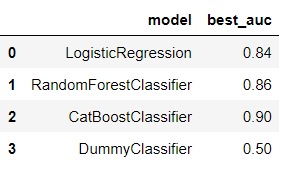

Модель CatBoostClassifier показала наиболее качественные результаты.

Особенных трудностей, по ходу выполнения работы не возникло.

Важными этапами при выполнения работы считаю были:

1) Этап вывода и ознакомления с данными

2) Анализ данных и выявление взаимосвязей с наглядным графическим отображением

3) Обработка пропусков и предобработка данных перед обучением моделей

4) Выбор и обучение модели

5) Проверка избранной модели и финальные выводы

В качестве признаков для дальнейшего обучения моделей были отобраны не все исходные данные, а именно, были исключены такие параметры как идентификационный номер клиента, дата начала договора, столбец с датой окончания договора и общая стоимость уплаченная клиентом за обслуживание. Последние были заменены на дополнительный признак - длительность обслуживания клиента, который считается как дата начала договора минус дата окончания договора для тех кто его разорвал либо дата предоставления данных для тех кто находится в обслуживании.

В результате проверки нескольких моделей, выбор пал на CatBoostClassifier со значением метрики ROC-AUC равной 0.92 и Accuracy 0.93, обученной на GridCV с лучшими параметрами: 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.3. Данная модель была проверена на тестовой выборке и показала наивысшую метрику ROC-AUC и Accuracy, в сравнении с другими рассмотренными моделями.

Минимальный порог метрики, установленной заказчиком (0.85), был пройден.

После проверки модели на тестовой выборке, была построена диаграмма важности признаков в предсказании.

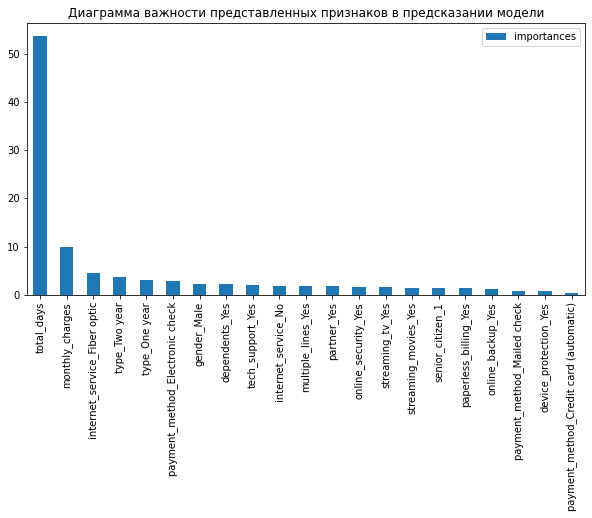

По нему видно, что наибольшей важностью обладает фактор того, сколько клиент пользуется услугами оператора, а также сколько он платит в месяц.

Также построили график ROC-кривой и матрицу ошибок.

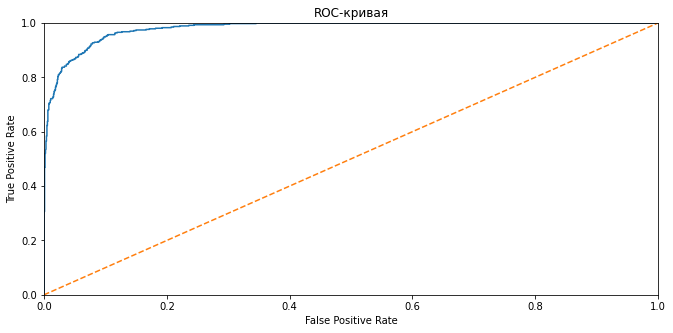

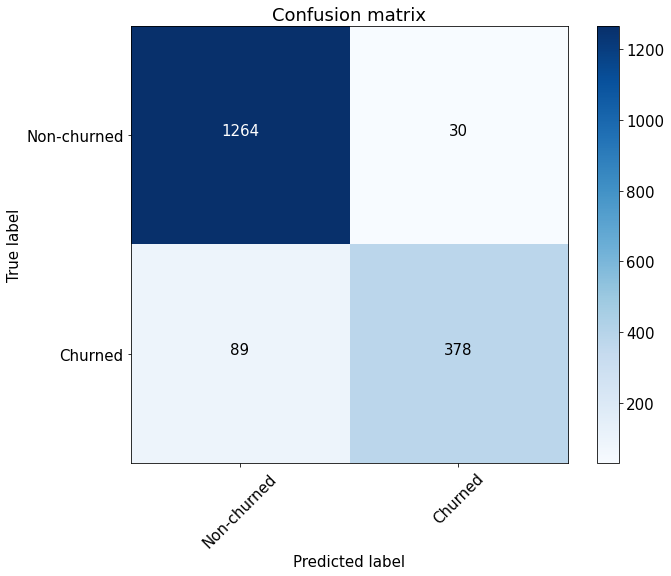

Судя по матрице ошибок, итоговые результаты выбранной модели достаточно неплохие - 1264 истинно положительных предсказанных значений и 378 истинно отрицательных значений.

Таким образом, обученную модель CatBoostClassifier можно использовать для определения потенциальных клиентов готовых уйти.